In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import pandas as pd
from datetime import datetime
import scipy.linalg as spla
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import random
markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'H', 'x', '+', '<', '>', '1', '2', '3', '4']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

def simple2DPlot(df, features):
    X = df[features]

    plt.figure(figsize=(8, 6))  # Tamaño opcional del gráfico

    plt.scatter(X[features[0]], X[features[1]], marker='o', color='blue', label='Ver')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.grid(True)  # Opcional: activa la cuadrícula
    plt.show()


In [2]:
df = pd.read_csv("../../datasets/LowOrbitSatelliteWithEclipses.csv", index_col='datetime')
ccantPanels     = 24
#TODO: Hacer DBScan
columns = ['vBatAverage', 
            'IInEclipse', 
            'BatteryEmergency',
            'BatterySaveMode',
            'BatteryOvertemp',
            'BatteryOvervoltage',
            'BatteryUndervoltage',
            'BatteryDischarging',
            'BatteryOvertemperature', 
            'bvrCycle',
            'ISenseRS1',
            'ISenseRS2',
            'cInEclipse',  
            'elapsedTime',
            ]
for i in range(ccantPanels):
    columns.append("V_MODULE_"+str(i+1)+"_SA")

features = ['V_MODULE_24_SA', 'vBatAverage']
print("Amount features: ", len(features), "features: ", features)



Amount features:  2 features:  ['V_MODULE_24_SA', 'vBatAverage']


In [3]:
epsilon = 0.5

In [4]:
#Como es una serie de tiempo mejor tomar valores random
df_red      = df.iloc[0:20100][features]
df_control  = df.iloc[20100:20115][features]
#df_red = df[features].sample(frac=0.5)

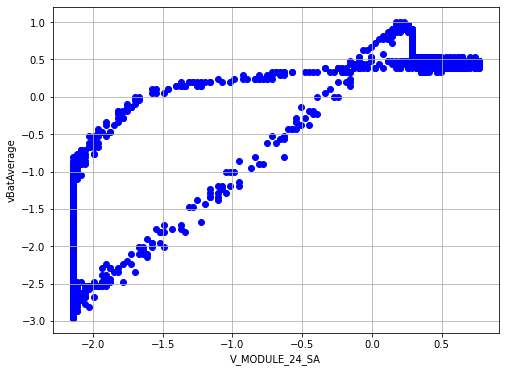

In [5]:
scaler=StandardScaler()
sdf = pd.DataFrame(scaler.fit_transform(df_red), columns=df_red.columns)
simple2DPlot(sdf, features)

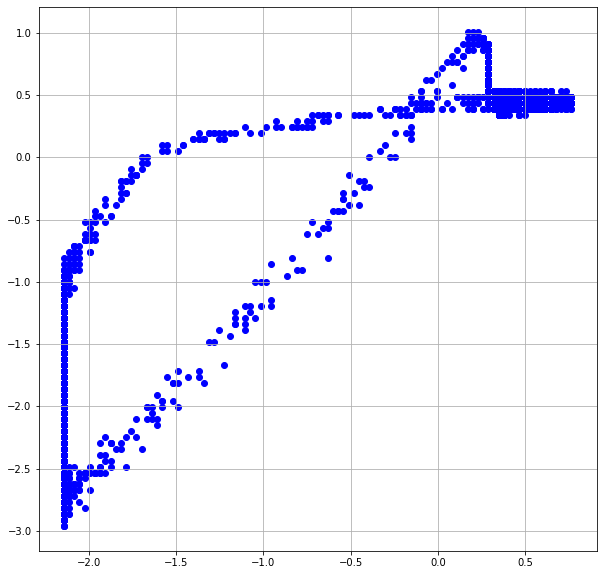

In [6]:
X = sdf
min_samples = 20
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
etiquetas = dbscan.fit_predict(X)
uet = np.unique(etiquetas)
X = X.assign(cluster = etiquetas)
i=0
fig, ax = plt.subplots(figsize=(10, 10))
for e in uet:
    ax.scatter(X[X["cluster"]==e][features[0]],X[X["cluster"]==e][features[1]], marker=markers[i%len(markers)], color=colors[i%len(colors)])
    i+=1     
plt.grid(True)  # Opcional: activa la cuadrícula
plt.show()

Iterativamente obtengo el epsilon que me deja todos los puntos en el mismo cluster.

In [7]:
scaler=StandardScaler()
xsdf = pd.DataFrame(scaler.fit_transform(df_red), columns=df_red.columns)
X = xsdf

In [8]:
#ahora busco min_samples
while True:
    bscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    dbscan.fit(X)
    num_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
    if num_clusters == 1:
        break  
    
    min_samples -= 1  # Aumenta el valor de epsilon e intenta de nuevo
print("Valor de min samples deseado:", min_samples)

Valor de min samples deseado: 20


In [9]:

epsilon = 0.1
while True:
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    dbscan.fit(X)
    num_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
    if num_clusters == 1:
        break  
    
    epsilon += 0.1  # Aumenta el valor de epsilon e intenta de nuevo
print("Valor de epsilon deseado:", epsilon)


Valor de epsilon deseado: 0.4


In [10]:
#Ahora a la parte sin escalar le sumo los valores anomalos
df_control['V_MODULE_24_SA']  = 130+random.randrange(1,5)
df_red_c_anomalies = pd.concat([df_red, df_control], axis=0)
scaler = StandardScaler()
sdf = pd.DataFrame(scaler.fit_transform(df_red_c_anomalies[features]), columns=df_red_c_anomalies[features].columns)

Alarma


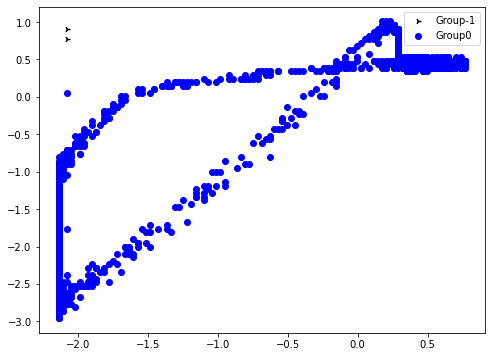

In [11]:

X = sdf[features]
dbscan = DBSCAN(eps=epsilon)
etiquetas = dbscan.fit_predict(X)
uet = np.unique(etiquetas)
etiquetas
X = X.assign(cluster = etiquetas)
plt.figure(figsize=(8, 6))  # Tamaño opcional del gráfico
if(len(uet)>1):
    print("Alarma")

for e in uet:
    x = X[X["cluster"]==e][features[0]]
    y = X[X["cluster"]==e][features[1]]
    plt.scatter(x, y, marker=markers[e%len(markers)], color=colors[e%len(colors)], label='Group'+str(e))

plt.legend()
plt.show()

Sin alarmas

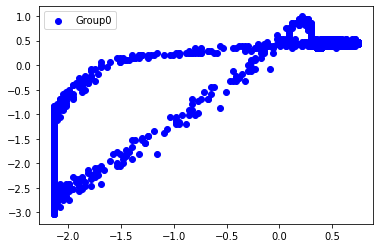

In [36]:
#Como es una serie de tiempo mejor tomar valores random
df_red      = df.iloc[20115:40000][features]
scaler=StandardScaler()
sdf = pd.DataFrame(scaler.fit_transform(df_red), columns=df_red.columns)
#simple2DPlot(sdf, features)
X = sdf
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
etiquetas = dbscan.fit_predict(X)
uet = np.unique(etiquetas)
X = X.assign(cluster = etiquetas)
if(len(uet)>1):
    print("Alarma")


for e in uet:
    x = X[X["cluster"]==e][features[0]]
    y = X[X["cluster"]==e][features[1]]
    plt.scatter(x, y, marker=markers[e%len(markers)], color=colors[e%len(colors)], label='Group'+str(e))

plt.legend()
plt.show()

